# Contour plots and integrals along and cross shelf of tracer concentration on shelf bottom, not counting the canyon lid



Map hcw on shelf by looking at bottom cells and multiplying their concentration by their area (weighted averagem [C]), then integrating these along the shelf and cross-shelf ([C]/m).

The canyon lid is not, strictly speaking, part of the shelf bottom, so I will leave it out of the average.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

import matplotlib as mpl

from matplotlib import gridspec

from math import *

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [2]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [3]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

NoCCanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCCanyonGridOut = Dataset(NoCCanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
PtracerOut = Dataset(Ptracer)

Ptracer12='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc'
PtracerOut12 = Dataset(Ptracer12)

Ptracer11='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc'
PtracerOut11 = Dataset(Ptracer11)

Ptracer30='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30/ptracersGlob.nc'
PtracerOut30 = Dataset(Ptracer30)

Ptracer07='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracerOut07 = Dataset(Ptracer07)

Ptracer25='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25/ptracersGlob.nc'
PtracerOut25 = Dataset(Ptracer25)

Ptracer24='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24/ptracersGlob.nc'
PtracerOut24 = Dataset(Ptracer24)

Ptracer3D04='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc'
PtracerOut3D04 = Dataset(Ptracer3D04)

Ptracer3D05='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc'
PtracerOut3D05 = Dataset(Ptracer3D05)

Ptracer3D06='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc'
PtracerOut3D06 = Dataset(Ptracer3D06)



In [4]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
bathyNoC = rout.getField(NoCCanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(NoCCanyonGrid, 'HFacC')
MaskCNoC = rout.getMask(NoCCanyonGrid, 'HFacC')
rANoC = rout.getField(NoCCanyonGrid, 'rA')
rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

In [5]:
Tr03 = rout.getField(Ptracer,'Tr1') # 


In [6]:
Tr07 = rout.getField(Ptracer07,'Tr1') # 

In [7]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                ConcArea[tt,i,j] = TrBottom*ra[i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    

    #ConcAreaMasked = np.ma.masked_values(ConcDepths,-2.5)
    #ConcDepths[np.where(np.ma.getmask(ConcDepthsMasked)==True)] = np.nan

    return (ConcArea,
            np.ma.masked_array(Conc, mask=maskShelf),
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [8]:
ConcArea1, Conc1, Conc1Filt, Area1 = ConcArea(Tr03, hFacC, rA, bathy)


(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
ConcArea1noc, Conc1noc, Conc1nocFilt, Area1noc = ConcArea(Tr07, hFacCNoC, rANoC, bathyNoC)

(360, 360)
(19, 360, 360)


/home/kramosmu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
def plot_pool(fig,data,depths,tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'Purples',fill_col='SlateBlue' ):
    '''
    INPUT:
    fig: figure object
    data: 3d slice of output (np. array with t,y,x dimensions)
    depths: 2d array bathymetry, same size as data.
    tt: time index
    x_2d: 2d array of xc
    y_2d: 2d array of yc
    x_vect: 1d array of xc
    y_vect: 1d array of yc
    maxCM: max value for contourf colormap
    minCM: min value for contourf colormap
    cmap: string with the name of the colormap to use. Default is 'Purples'.
    fill_col: string with fill color for marginal line plots. Default is 'SlateBlue'.
    
    
    '''

    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    xmin = x_vect.min()
    xmax = x_vect.max()
    ymin = y_vect.min()
    ymax = y_vect.max()

    #Set style to white
    sns.set_style('white')

    #Define grid for subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])

    #Create contour plot
    ax = plt.subplot(gs[1,0])
    caxf = ax.contourf(x_2d,y_2d,data,15, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    bax = ax.contour(x_2d,y_2d,depths,[60,80,100,120,147.5], colors = '0.5')
    plt.clabel(bax, inline=1, fontsize=13)
    
    cax = ax.contour(x_2d,y_2d,data,7,colors = 'k')
    plt.clabel(cax, inline=1, fontsize=13)

    ax.set_xlabel('Alongshore distance [km]')
    ax.set_ylabel('Cross-shore distance [km]')

    #Turn on all axes
    ax.axis('on')

    #Create Y-marginal (right)
    axr = plt.subplot(gs[1,1], frameon = True,yticks=[],xlim=(data_mean_y.min(), data_mean_y.max()), ylim=(ymin, ymax) )
    axr.plot(data_mean_y, y_vect, color = 'black')
    axr.fill_betweenx(y_vect, 0, data_mean_y, alpha = .75, color = fill_col )
    axr.set_xlabel('mean BAC [(Mol/l)/m]')

    #Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = True, xticks=[], xlim = (xmin, xmax), ylim=(data_mean_x.min(), data_mean_x.max()))
    axt.plot(x_vect, data_mean_x, color = 'black')
    axt.fill_betweenx(data_mean_x, 0, x_vect, alpha = .75, color = fill_col)
    
    TEXT_OBJ = ax.text(1.1, 1.15, ('Day %1.1f ' %(tt/2.0)), transform=ax.transAxes, fontsize=20)
    
    #Bring the marginals closer to the contour plot
    fig.tight_layout(pad = 1)
    
    



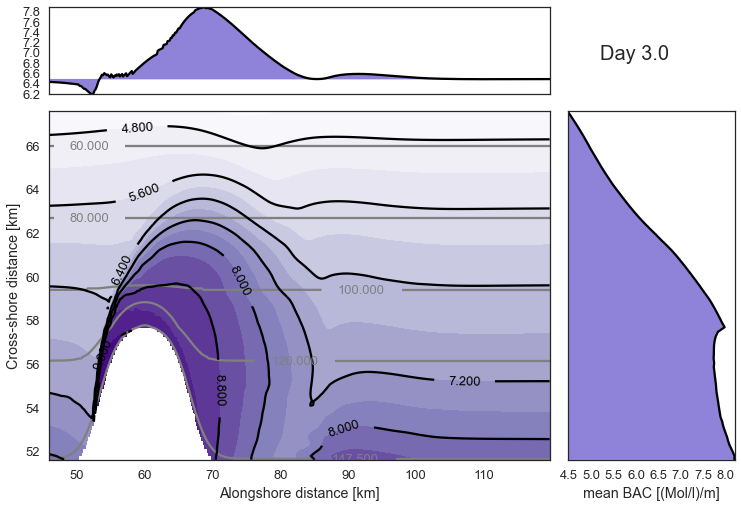

In [54]:
tt=6
y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

data = Conc1Filt[tt,227:300,100:]
maxCM = 10
minCM = 4.4

fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'Purples')


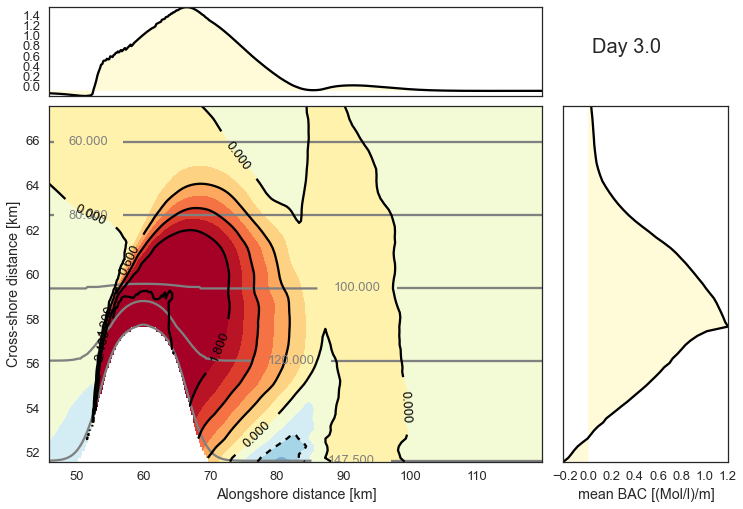

In [55]:
data = Conc1Filt[tt,227:300,100:]-Conc1nocFilt[tt,227:300,100:]
maxCM = 1.8
minCM = -1.8
fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],tt,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


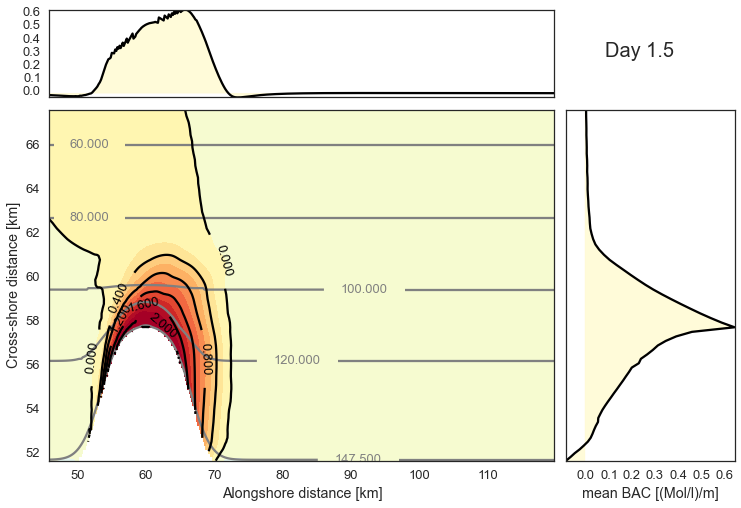

In [56]:
data = Conc1Filt[3,227:300,100:]-Conc1nocFilt[3,227:300,100:]
maxCM = 1.8
minCM = -1.8
fig = plt.figure()
    
plot_pool(fig,data,bathy[227:300,100:],3,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,cmap = 'RdYlBu_r',fill_col='LemonChiffon')

In [12]:
def anim_pool(fig,data,depths,tt,x2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx,cmap = 'Purples',fill_col='SlateBlue' ):

    data_mean_x = np.nanmean(data,axis=0)
    data_mean_y = np.nanmean(data,axis=1)

    xmin = x_vect.min()
    xmax = x_vect.max()
    ymin = y_vect.min()
    ymax = y_vect.max()

    #Set style to white
    sns.set_style('white')

    #Define grid for subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 4])

    #Create contour plot
    ax = plt.subplot(gs[1,0])
    caxf = ax.contourf(x_2d,y_2d,data,15, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    bax = ax.contour(x_2d,y_2d,depths,[60,80,100,120,147.5], colors = '0.5')
    plt.clabel(bax, inline=1, fontsize=13)
    
    cax = ax.contour(x_2d,y_2d,data,7,colors = 'k')
    plt.clabel(cax, inline=1, fontsize=13)

    ax.set_xlabel('Alongshore distance [km]')
    ax.set_ylabel('Cross-shore distance [km]')

    #Turn on all axes
    ax.axis('on')

    #Create Y-marginal (right)
    axr = plt.subplot(gs[1,1], frameon = True,yticks=[],xlim=(minXy, maxXy), ylim=(ymin, ymax) )
    axr.plot(data_mean_y, y_vect, color = 'black')
    axr.fill_betweenx(y_vect, 0, data_mean_y, alpha = .75, color = fill_col )
    axr.set_xlabel('mean BAC [(Mol/l)/m]')

    #Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = True, xticks=[], xlim = (xmin, xmax), ylim=(minYx, maxYx))
    axt.plot(x_vect, data_mean_x, color = 'black')
    axt.fill_betweenx(data_mean_x, 0, x_vect, alpha = .75, color = fill_col)
    
    TEXT_OBJ = ax.text(1.1, 1.15, ('Day %1.1f ' %(tt/2.0)), transform=ax.transAxes, fontsize=20)
    #Bring the marginals closer to the contour plot
    fig.tight_layout(pad = 1)
    
    return (fig)



## Animations

In [60]:
import matplotlib.animation as animation


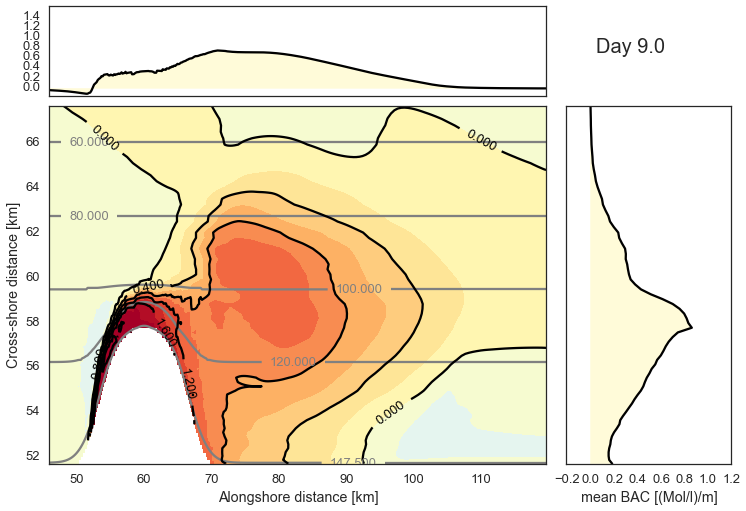

In [61]:
# Time index

starttime = 0
data = Conc1Filt[starttime,227:300,100:]-Conc1nocFilt[starttime,227:300,100:]
data_all_times = Conc1Filt[:,227:300,100:]-Conc1nocFilt[:,227:300,100:]

maxCM = 1.8
minCM = -1.8

minXy = np.min(np.nanmean(data_all_times,axis=2)) 
maxXy = np.max(np.nanmean(data_all_times,axis=2))
minYx = np.min(np.nanmean(data_all_times,axis=1))
maxYx = np.max(np.nanmean(data_all_times,axis=1))

fig = plt.figure()
    
anim_pool(fig,data,bathy[227:300,100:],starttime,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


def next_frame(t):
    
    timeIndex = starttime + t 
    data = Conc1Filt[timeIndex,227:300,100:]-Conc1nocFilt[timeIndex,227:300,100:]
    anim_pool(fig,data,bathy[227:300,100:],timeIndex,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx,cmap = 'RdYlBu_r',fill_col='LemonChiffon')
    
    
    
    
# Animate
ANI = animation.FuncAnimation(fig, next_frame, frames=19)
mywriter = animation.FFMpegWriter(fps=3, bitrate=10000)
#ANI.save('/ocean/kramosmu/pool_anomaly_basecase.mp4', writer=mywriter)



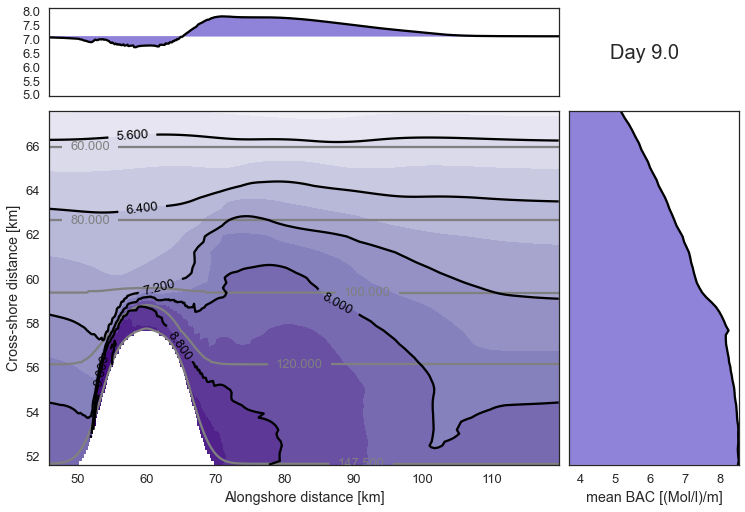

In [62]:
# Time index

starttime = 0
data = Conc1Filt[starttime,227:300,100:]
data_all_times = Conc1Filt[:,227:300,100:]

maxCM = 10
minCM = 4.4

minXy = np.min(np.nanmean(data_all_times,axis=2)) 
maxXy = np.max(np.nanmean(data_all_times,axis=2))
minYx = np.min(np.nanmean(data_all_times,axis=1))
maxYx = np.max(np.nanmean(data_all_times,axis=1))

fig = plt.figure()
    
anim_pool(fig,data,bathy[227:300,100:],starttime,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx)

def next_frame(t):
    
    timeIndex = starttime + t 
    data = Conc1Filt[timeIndex,227:300,100:]
    anim_pool(fig,data,bathy[227:300,100:],timeIndex,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx)
    
    
    
# Animate
ANI = animation.FuncAnimation(fig, next_frame, frames=19)
mywriter = animation.FFMpegWriter(fps=3, bitrate=10000)
#ANI.save('/ocean/kramosmu/pool_basecase.mp4', writer=mywriter)



## Save frames for beamer animation

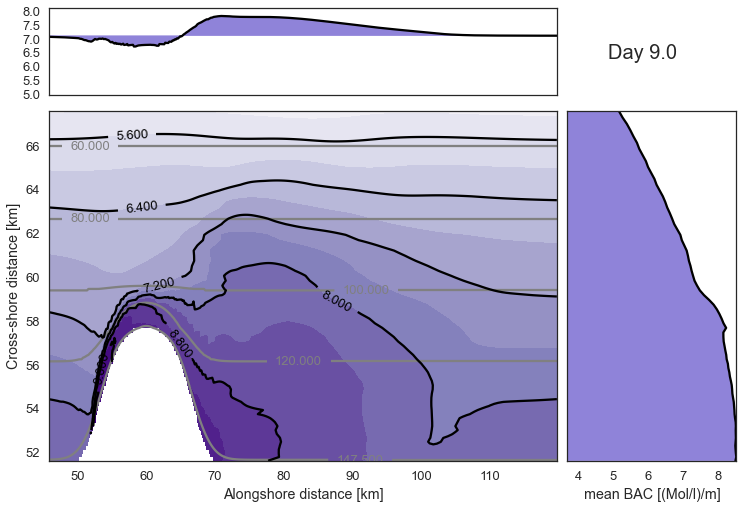

In [63]:
starttime = 0
data = Conc1Filt[starttime,227:300,100:]
data_all_times = Conc1Filt[:,227:300,100:]

maxCM = 10
minCM = 4.4

minXy = np.min(np.nanmean(data_all_times,axis=2)) 
maxXy = np.max(np.nanmean(data_all_times,axis=2))
minYx = np.min(np.nanmean(data_all_times,axis=1))
maxYx = np.max(np.nanmean(data_all_times,axis=1))

fig = plt.figure()
    
for tt in range(19):
    
    next_frame(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolHighConcentration/pool_basecase_tt%02d.png' %tt) 
    #plt.savefig(frame_name2,  format='png')



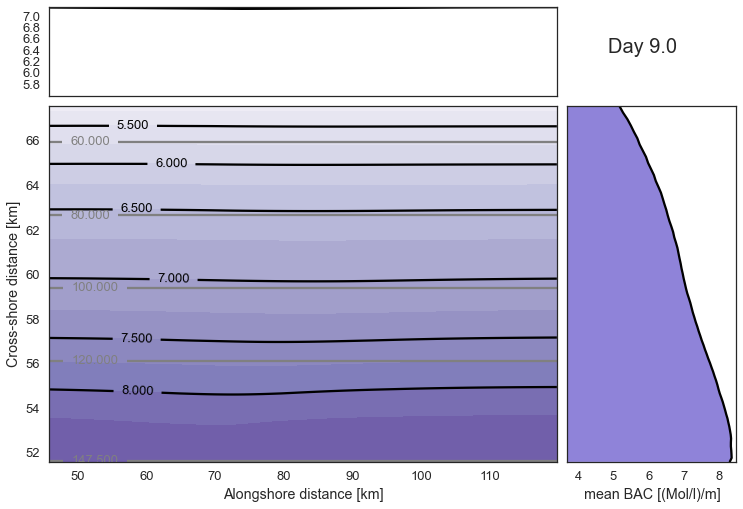

In [19]:
def next_frame_NoC(t):
    
    timeIndex = starttime + t 
    data = Conc1nocFilt[timeIndex,227:300,100:]
    anim_pool(fig,data,bathyNoC[227:300,100:],timeIndex,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx)
 
starttime = 0
data = Conc1nocFilt[starttime,227:300,100:]
data_all_times = Conc1nocFilt[:,227:300,100:]

maxCM = 10
minCM = 4.4

y_vect = yc[227:300,100]/1000.0
x_vect = xc[227,100:]/1000.0

y_2d = yc[227:300,100:]/1000.0
x_2d = xc[227:300,100:]/1000.0

minXy = np.min(np.nanmean(data_all_times,axis=2)) 
maxXy = np.max(np.nanmean(data_all_times,axis=2))
minYx = np.min(np.nanmean(data_all_times,axis=1))
maxYx = np.max(np.nanmean(data_all_times,axis=1))

fig = plt.figure()
    
for tt in range(19):
    
    next_frame_NoC(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolHighConcentration/pool_baseNoCcase_tt%02d.png' %tt) 
    #plt.savefig(frame_name2,  format='png')



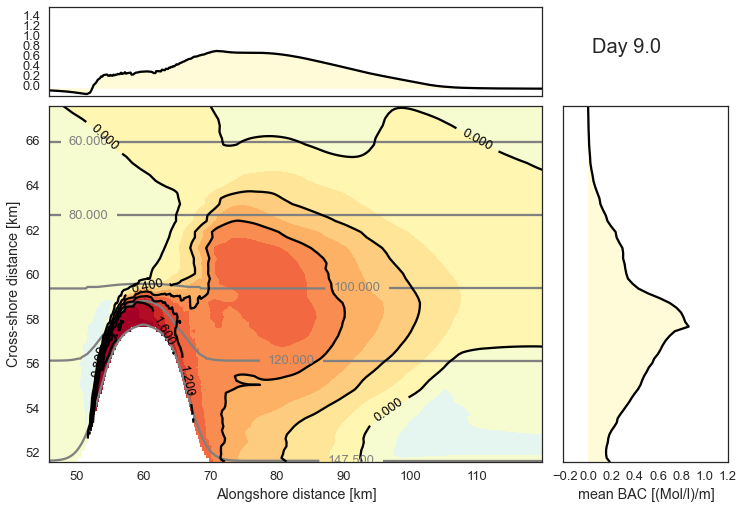

In [64]:
# Time index

starttime = 0
data = Conc1Filt[starttime,227:300,100:]-Conc1nocFilt[starttime,227:300,100:]
data_all_times = Conc1Filt[:,227:300,100:]-Conc1nocFilt[:,227:300,100:]

maxCM = 1.8
minCM = -1.8

minXy = np.min(np.nanmean(data_all_times,axis=2)) 
maxXy = np.max(np.nanmean(data_all_times,axis=2))
minYx = np.min(np.nanmean(data_all_times,axis=1))
maxYx = np.max(np.nanmean(data_all_times,axis=1))

fig = plt.figure()
    
anim_pool(fig,data,bathy[227:300,100:],starttime,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx,cmap = 'RdYlBu_r',fill_col='LemonChiffon')


def next_frame(t):
    
    timeIndex = starttime + t 
    data = Conc1Filt[timeIndex,227:300,100:]-Conc1nocFilt[timeIndex,227:300,100:]
    anim_pool(fig,data,bathy[227:300,100:],timeIndex,x_2d,y_2d,x_vect,y_vect,maxCM,minCM,minXy,maxXy,minYx,maxYx,cmap = 'RdYlBu_r',fill_col='LemonChiffon')
    

for tt in range(19):
    
    next_frame(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolHighConcentration/pool_basecase_anom_tt%02d.png' %tt) 
    #plt.savefig(frame_name2,  format='png')

